In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import random

import dask.dataframe as dd

sys.path.append("../")
from src.utils import *
from src.LSN_roi import *
from src.simul import *

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
project_dir = "../"
metadata_dir = f"{project_dir}/metadata/"
data_dir = "/home/nikhil/projects/brain_changes/data/"

freesurfer_fields = f"{metadata_dir}brainage_fs_ukbb_field_ids.csv"
train_csv = f"{metadata_dir}metadata_train.csv"
test_csv = f"{metadata_dir}metadata_test.csv"

# ukbb
ukbb_demograph_csv = f"{data_dir}ukbb/tabular/ukbb_follow_up_demographics.csv"
ukbb_FS_csv = f"{data_dir}ukbb/imaging/freesurfer/ukb47552_followup_subset.csv"


# adni
adni_demograph_csv = f"{data_dir}adni/metadata/ADNIMERGE.csv"
adni_FS_DKT_csv = f"{data_dir}adni/imaging/freesurfer/adni_followup_subset_DKT.csv"
adni_FS_aseg_csv = f"{data_dir}adni/imaging/freesurfer/adni_followup_subset_aseg.csv"

# results
summary_results_dir = f"{project_dir}/results/summary/ohbm2022/"


## Grab phenotype fields (e.g. Thicknes, Volume, Area)

In [4]:
freesurfer_fields_df = pd.read_csv(freesurfer_fields)

CT_fields = freesurfer_fields_df[freesurfer_fields_df["stat"]=="DKT"]["Field ID"]
volume_fields = freesurfer_fields_df[freesurfer_fields_df["stat"]=="aseg"]["Field ID"]

print(f"number of CT fields: {len(CT_fields)}, volume fields: {len(volume_fields)}")

number of CT fields: 62, volume fields: 36


### Pick phenotype

In [5]:
FS_measures = "DKT"

if FS_measures == "DKT":
    pheno_fields = CT_fields
elif FS_measures == "aseg":
    pheno_fields = volume_fields
else:
    pheno_fields = CT_fields.append(volume_fields)

pheno_cols_ses2 = list(pheno_fields.astype(str) + "-2.0")
pheno_cols_ses3 = list(pheno_fields.astype(str) + "-3.0")
usecols = ["eid"] + pheno_cols_ses2 + pheno_cols_ses3

print(f"Using {FS_measures} features with 2 timepoints i.e. {len(usecols)} columns")

Using DKT features with 2 timepoints i.e. 125 columns


### Read UKBB FreeSurfer data

In [6]:
print(f"reading {len(usecols)} columes")
ukbb_freesurfer_df = pd.read_csv(ukbb_FS_csv, usecols=usecols)

# Remove eids with missing 2nd or 3rd ses data
eid_missing_data = ukbb_freesurfer_df[ukbb_freesurfer_df.isna().any(axis=1)]["eid"].values
print(f"number participants missing 2nd or 3rd ses freesurfer data: {len(eid_missing_data)}")

ukbb_freesurfer_df = ukbb_freesurfer_df[~ukbb_freesurfer_df["eid"].isin(eid_missing_data)]
freesurfer_eids = ukbb_freesurfer_df["eid"].values

print(f"available freesurfer subjects: {len(freesurfer_eids)}")
# ukbb_freesurfer_df = ukbb_freesurfer_df.rename(columns={"eid":"subject_id"})
ukbb_freesurfer_df = ukbb_freesurfer_df.set_index("eid")

## Some outlier that need to be looked at (most likely proc failures)
drop_subjects = [1293173] #1293173 --> super high CT change

ukbb_freesurfer_df = ukbb_freesurfer_df.drop(drop_subjects)

# Split visits
BL_ukbb_freesurfer_df = ukbb_freesurfer_df[pheno_cols_ses2]
BL_ukbb_freesurfer_df = BL_ukbb_freesurfer_df.rename(columns=dict(zip(pheno_cols_ses2, pheno_fields)))
FU_ukbb_freesurfer_df = ukbb_freesurfer_df[pheno_cols_ses3]
FU_ukbb_freesurfer_df = FU_ukbb_freesurfer_df.rename(columns=dict(zip(pheno_cols_ses3, pheno_fields)))

print(f"BL shape: {BL_ukbb_freesurfer_df.shape}, FU shape: {FU_ukbb_freesurfer_df.shape}")

print(f"Number dropped subjects: {len(drop_subjects)}")

ukbb_freesurfer_df.head()

reading 125 columes
number participants missing 2nd or 3rd ses freesurfer data: 63
available freesurfer subjects: 3237
BL shape: (3236, 62), FU shape: (3236, 62)
Number dropped subjects: 1


,27174-2.0,27174-3.0,27175-2.0,27175-3.0,27176-2.0,27176-3.0,27177-2.0,27177-3.0,27178-2.0,27178-3.0,...,27293-2.0,27293-3.0,27294-2.0,27294-3.0,27295-2.0,27295-3.0,27296-2.0,27296-3.0,27297-2.0,27297-3.0
eid,,,,,,,,,,,,,,,,,,,,,
1000635,2.786,2.874,2.910,2.852,2.275,2.307,3.389,3.379,2.836,2.815,...,2.387,2.435,2.967,2.958,2.707,2.628,2.229,2.142,2.875,2.750
1008391,3.191,2.875,3.080,3.037,2.273,2.143,3.004,2.571,2.846,2.753,...,2.588,2.592,3.073,2.859,2.839,2.770,3.086,3.322,3.255,3.003
1010129,2.329,1.870,2.836,2.798,1.995,1.943,3.302,3.193,2.812,2.801,...,2.376,2.395,3.081,3.086,2.993,2.945,3.016,3.032,3.193,3.168
1010994,2.785,2.581,2.671,2.603,2.060,1.819,3.144,3.225,2.793,2.678,...,2.513,2.416,2.919,2.881,2.654,2.581,2.088,2.161,2.912,2.866
1013774,2.963,3.191,2.617,2.856,2.035,2.050,2.751,3.385,2.830,2.949,...,2.274,2.403,3.041,3.008,2.635,2.737,2.527,2.696,2.983,3.263


## Create train and test sets

In [7]:
chronage_delta_thresh = 10 # maximum age difference between visits, trained models don't change for thresh=2

train_df = pd.read_csv(train_csv)
train_eids = train_df["eid"]
train_eids_avail = set(train_eids) & set(freesurfer_eids)
train_df = pd.merge(train_df, ukbb_freesurfer_df, on="eid", how="inner")
train_df["chronoage_delta"] = train_df["age_at_ses3"] - train_df["age_at_ses2"]
train_df = train_df[train_df["chronoage_delta"] <= chronage_delta_thresh]

test_df = pd.read_csv(test_csv)
test_eids = test_df["eid"]
test_eids_avail = set(test_eids) & set(freesurfer_eids)
test_df = pd.merge(test_df, ukbb_freesurfer_df, on="eid", how="inner")
test_df["chronoage_delta"] = test_df["age_at_ses3"] - test_df["age_at_ses2"]
test_df = test_df[test_df["chronoage_delta"] <= chronage_delta_thresh]


print(f"train samples: {len(train_eids)}, freesurfer data available: {len(train_eids_avail)}, overlap: {len(train_df)}")
print(f"test samples: {len(test_eids)}, freesurfer data available: {len(test_eids_avail)}, overlap: {len(test_df)}")



train samples: 2145, freesurfer data available: 1909, overlap: 1908
test samples: 1057, freesurfer data available: 958, overlap: 958


## Add ADNI test set

In [8]:
adnimerge_df = pd.read_csv(adni_demograph_csv)

print(f"ADNIMERGE len: {len(adnimerge_df)}")

adnimerge_df["subject_id"] = "sub-ADNI" + adnimerge_df["PTID"]
adnimerge_df["subject_id"] = adnimerge_df["subject_id"].str.replace("_","")

useful_cols = ["subject_id","DX_bl","AGE","PTGENDER","VISCODE"]
adnimerge_dx_df = adnimerge_df[(adnimerge_df["VISCODE"]=="bl")][useful_cols]

print(f"adnimerge with longitudinal subjects. n_subjects = {len(adnimerge_dx_df)}")
adnimerge_dx_df.head()

ADNIMERGE len: 11483
adnimerge with longitudinal subjects. n_subjects = 1735


,subject_id,DX_bl,AGE,PTGENDER,VISCODE
0,sub-ADNI011S0002,CN,74.3,Male,bl
1,sub-ADNI011S0003,AD,81.3,Male,bl
5,sub-ADNI022S0004,LMCI,67.5,Male,bl
10,sub-ADNI011S0005,CN,73.7,Male,bl
15,sub-ADNI100S0006,LMCI,80.4,Female,bl


In [9]:
if FS_measures == "DKT":
    adni_freesurfer_df = pd.read_csv(adni_FS_DKT_csv).set_index("subject_id")
elif FS_measures == "aseg":
    adni_freesurfer_df = pd.read_csv(adni_FS_aseg_csv).set_index("subject_id")
else:
    df1 = pd.read_csv(adni_FS_DKT_csv).set_index("subject_id")
    df2 = pd.read_csv(adni_FS_aseg_csv).set_index("subject_id")

    adni_freesurfer_df = pd.concat([df1,df2],axis=1)

adni_subjects = adni_freesurfer_df.index
print(f"Number of ADNI subjects: {len(adni_subjects)}")

adnimerge_dx_df = adnimerge_dx_df[(adnimerge_dx_df["subject_id"].isin(adni_subjects))]

adni_freesurfer_df = pd.merge(adni_freesurfer_df, adnimerge_dx_df[["subject_id","AGE","DX_bl"]], on="subject_id")

adni_freesurfer_df.head()

Number of ADNI subjects: 267


,subject_id,27174-2.0,27175-2.0,27176-2.0,27177-2.0,27178-2.0,27179-2.0,27180-2.0,27181-2.0,27182-2.0,...,27290-3.0,27291-3.0,27292-3.0,27293-3.0,27294-3.0,27295-3.0,27296-3.0,27297-3.0,AGE,DX_bl
0,sub-ADNI019S4285,2.635,2.728,1.956,3.227,2.857,2.382,2.856,2.408,2.111,...,2.731,2.337,2.620,2.180,2.777,2.606,2.792,2.938,74.0,EMCI
1,sub-ADNI116S4453,2.334,2.350,1.829,3.573,2.568,2.149,2.552,2.226,2.018,...,2.775,2.050,2.399,1.877,2.640,2.192,2.300,2.605,65.9,CN
2,sub-ADNI116S4625,2.332,2.095,1.936,2.606,2.501,2.063,2.668,2.228,2.129,...,2.473,2.236,2.267,2.095,2.759,2.568,2.516,2.981,63.8,AD
3,sub-ADNI011S4893,2.582,2.401,1.948,3.188,2.541,2.195,2.587,2.078,2.189,...,2.572,2.265,2.321,2.053,2.527,2.380,1.953,2.695,68.1,EMCI
4,sub-ADNI037S4410,2.447,2.482,2.100,3.147,2.510,2.247,2.480,2.383,2.081,...,2.619,2.214,2.471,2.123,2.703,2.367,2.511,2.674,69.1,CN


## Train models
- RF, Ridge

In [10]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

n_jobs = 4

add_adni = True 

model_dict = {
            "Ridge": Ridge(), 
            "RF": RandomForestRegressor(n_jobs=n_jobs, random_state=1)
            }

perf_df = pd.DataFrame()

for data_aug in [False]:

    if data_aug:
        X_baseline_CV = train_df[pheno_cols_ses2].values
        X_followup_CV = train_df[pheno_cols_ses3].values
        y_baseline_CV = train_df["age_at_ses2"].values
        y_followup_CV = train_df["age_at_ses3"].values

        X_CV, y_CV = augment_data(X_baseline_CV, X_followup_CV, y_baseline_CV, y_followup_CV, swap_only=True)

    else:
        X_CV = train_df[pheno_cols_ses2 + pheno_cols_ses3].values
        y_CV = train_df[["age_at_ses2", "age_at_ses3"]].values

    print(f"shapes X_CV: {X_CV.shape}, y_CV: {y_CV.shape}")

    # ukbb
    X_test = test_df[pheno_cols_ses2 + pheno_cols_ses3].values
    y_test = test_df[["age_at_ses2", "age_at_ses3"]].values

    print(f"shapes  X_test: {X_test.shape}, y_test: {y_test.shape}")

    # adni
    if add_adni:
        print(f"adding adni test set")
        X_test_adni = adni_freesurfer_df[pheno_cols_ses2 + pheno_cols_ses3].values
        y_test_adni = np.vstack(zip(adni_freesurfer_df["AGE"].values, adni_freesurfer_df["AGE"].values + 2)) 
    
        X_test = np.concatenate([X_test,X_test_adni],axis=0)
        y_test = np.concatenate([y_test,y_test_adni],axis=0)

        print(f"shapes  X_test: {X_test.shape}, y_test: {y_test.shape}")
    

    for model_name, model_instance in model_dict.items():        
        CV_scores, y_pred, test_loss1, test_loss2, test_r1, test_r2 = get_brain_age_perf(X_CV, y_CV, X_test, y_test, model_instance)

        df = pd.DataFrame()
        if add_adni:
            df["eid"] = list(test_df["eid"].astype(str)) + list(adni_freesurfer_df["subject_id"])
            df["cohort"] = ["ukbb"] * len(test_df) + ["adni"] * len(adni_freesurfer_df)
            df["Dx"] = ["ukbb-CN"] * len(test_df) + list(adni_freesurfer_df["DX_bl"])
        else:
            df["eid"] = test_df["eid"]

        df["age_at_ses2"] = y_test[:,0]
        df["age_at_ses3"] = y_test[:,1]
        df["brainage_at_ses2"] = y_pred[:,0]
        df["brainage_at_ses3"] = y_pred[:,1]
        df["test_loss1"] = test_loss1                    
        df["test_loss2"] = test_loss2
        df["test_r1"] = test_r1
        df["test_r2"] = test_r2
        df["model"] = model_name
        df["data_aug"] = data_aug
        perf_df = perf_df.append(df)

shapes X_CV: (1908, 124), y_CV: (1908, 2)
shapes  X_test: (958, 124), y_test: (958, 2)
adding adni test set
shapes  X_test: (1225, 124), y_test: (1225, 2)


ipykernel_launcher:42: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


### Calculate various errors

In [11]:
# visits
perf_df["baseline_err"] = perf_df["brainage_at_ses2"] - perf_df["age_at_ses2"]
perf_df["followup_err"] = perf_df["brainage_at_ses3"] - perf_df["age_at_ses3"]
perf_df["baseline_abs_err"] = np.abs(perf_df["baseline_err"])
perf_df["followup_abs_err"] = np.abs(perf_df["followup_err"])

# deltas
perf_df["brainage_delta"] = perf_df["brainage_at_ses3"] - perf_df["brainage_at_ses2"]
perf_df["chronoage_delta"] = perf_df["age_at_ses3"] - perf_df["age_at_ses2"]
perf_df["delta_err"] = perf_df["brainage_delta"] - perf_df["chronoage_delta"]
perf_df["delta_abs_err"] = np.abs(perf_df["delta_err"])

perf_df["Benjamin_Button"] = perf_df["brainage_at_ses3"] < perf_df["brainage_at_ses2"]

n_BBs = perf_df["Benjamin_Button"].sum()
print(f"n BBs: {n_BBs} ({100*n_BBs/len(perf_df):4.3f}%)")

perf_df.head()

n BBs: 0 (0.000%)


,eid,cohort,Dx,age_at_ses2,age_at_ses3,brainage_at_ses2,brainage_at_ses3,test_loss1,test_loss2,test_r1,...,data_aug,baseline_err,followup_err,baseline_abs_err,followup_abs_err,brainage_delta,chronoage_delta,delta_err,delta_abs_err,Benjamin_Button
0,4071544,ukbb,ukbb-CN,66.0,68.0,66.838666,69.038099,0.703361,1.077649,0.652949,...,False,0.838666,1.038099,0.838666,1.038099,2.199433,2.0,0.199433,0.199433,False
1,6005293,ukbb,ukbb-CN,61.0,63.0,64.177180,66.426670,10.094470,11.742067,0.652949,...,False,3.177180,3.426670,3.177180,3.426670,2.249490,2.0,0.249490,0.249490,False
2,5739520,ukbb,ukbb-CN,61.0,63.0,65.219927,67.329961,17.807785,18.748565,0.652949,...,False,4.219927,4.329961,4.219927,4.329961,2.110034,2.0,0.110034,0.110034,False
3,1308382,ukbb,ukbb-CN,51.0,53.0,61.888516,64.170480,118.559774,124.779631,0.652949,...,False,10.888516,11.170480,10.888516,11.170480,2.281965,2.0,0.281965,0.281965,False
4,2991501,ukbb,ukbb-CN,58.0,60.0,55.281438,57.791154,7.390581,4.878999,0.652949,...,False,-2.718562,-2.208846,2.718562,2.208846,2.509717,2.0,0.509717,0.509717,False


### Save summary results

In [12]:
save_summary_results = False
if save_summary_results:
    results_name = "two_visit_baseline_perf.csv"
    perf_df.to_csv(f"{summary_results_dir}{results_name}")

### Plots

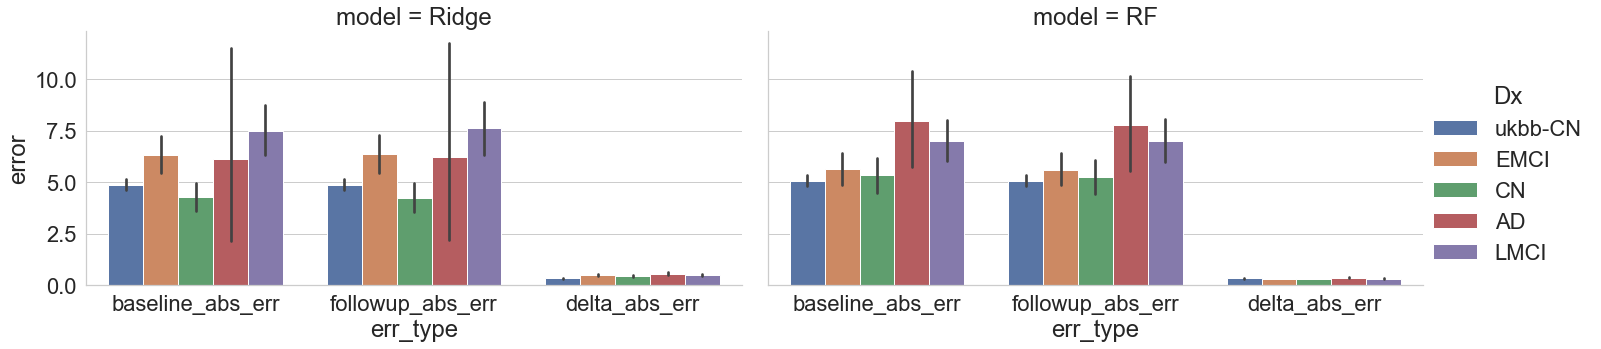

In [15]:
chronage_delta_thresh = 2
plot_abs_err = True

plot_df = perf_df.copy()
plot_df = plot_df[plot_df["chronoage_delta"] <= chronage_delta_thresh]

plot_df_melt = plot_df.melt(id_vars=["eid","cohort", "Dx", "model", "data_aug","age_at_ses2", "brainage_at_ses2", 
"age_at_ses3", "brainage_at_ses3", "chronoage_delta", "brainage_delta"], 
              value_vars=['baseline_err', 'followup_err', 'delta_err','baseline_abs_err', 'followup_abs_err', 'delta_abs_err'],
              var_name='err_type', value_name='error')

if plot_abs_err:
    plot_df_melt = plot_df_melt[plot_df_melt["err_type"].isin(['baseline_abs_err', 'followup_abs_err', 'delta_abs_err'])]
else:
    plot_df_melt = plot_df_melt[plot_df_melt["err_type"].isin(['baseline_err', 'followup_err', 'delta_err'])]
    
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    # fig, ax = plt.subplots(figsize=(20,10))
    g = sns.catplot(x="err_type",y="error", hue="Dx", col="model",kind="bar", data=plot_df_melt, aspect=2)


In [ ]:
chronage_delta_thresh = 2

plot_df = perf_df.copy()
plot_df = plot_df[plot_df["chronoage_delta"] <= chronage_delta_thresh]

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.displot(x="delta_err", col="model",hue="Dx",kind="ecdf", data=plot_df)